In [1]:
!pip install d2l==0.14.4

     |████████████████████████████████| 58 kB 5.5 MB/s eta 0:00:011


In [1]:
from d2l import torch as d2l
import torch
from torch import nn

# Encoder

In [2]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)  # X shape: (batch_size, seq_len, embed_size)
        # RNN needs first axes to be time step, i.e., seq_len
        X = X.permute(1, 0, 2)
        out, state = self.rnn(X) # When state is not mentioned, it defaults to zeros
        # out shape: (seq_len, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens),
        # where "state" contains the hidden state and the memory cell
        return out, state

In [3]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, type(state)

(torch.Size([7, 4, 16]), tuple)

# Decoder

In [4]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation
        out = self.dense(out).permute(1, 0, 2)
        return out, state

In [5]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 7, 10]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

# Loss Function

In [6]:
def sequence_mask(X, valid_len, value=0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [7]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    # pred shape: (batch_size, seq_len, vocab_size)
    # label shape: (batch_size, seq_len)
    # valid_len shape: (batch_size, )
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0,2,1), label)
        weighted_loss = (unweighted_loss*weights).mean(dim=1)
        return weighted_loss

In [8]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

# Training

In [9]:
def train_s2s_ch9(model, data_iter, lr, num_epochs, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.LSTM:
            for param in m._flat_weights_names:
                if "weight" in param:
                    torch.nn.init.xavier_uniform_(m._parameters[param])
    model.apply(xavier_init_weights)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    model.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], ylim=[0, 0.25])
    for epoch in range(1, num_epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        for batch in data_iter:
            X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen-1
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            l = loss(Y_hat, Y_label, Y_vlen)
            l.sum().backward() # Making the loss scalar for backward()
            d2l.grad_clipping(model, 1)
            num_tokens = Y_vlen.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if epoch % 10 == 0:
            animator.add(epoch, (metric[0]/metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.025, 14602.4 tokens/sec on cuda:0


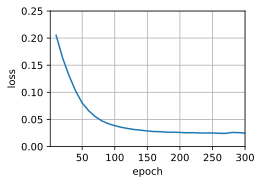

In [10]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s_ch9(model, train_iter, lr, num_epochs, device)

# Prediction

In [21]:
def predict_s2s_ch9(model, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.tensor(src_tokens, dtype=torch.long, device=device)
    # Add the  batch size dimension
    enc_outputs = model.encoder(torch.unsqueeze(enc_X, dim=0),
                                enc_valid_len)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    predict_tokens = []
    for _ in range(num_steps):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # The token with highest score is used as the next time step input
        dec_X = Y.argmax(dim=2)
        py = dec_X.squeeze(dim=0).type(torch.int32).item()
        if py == tgt_vocab['<eos>']:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

In [22]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, device))

Go . => va !
Wow ! => <unk> !
I'm OK . => ça va .
I won ! => je l'ai emporté !
